In [45]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import warnings
warnings.filterwarnings('ignore')

# Todo

1) relying on "predict" to predict: instead, use the decision function and tune a decision threshold
- experiment: a variety of dataset imbalance levels.  compare:
    - raw data, use "predict"
    - balanced data, use "predict"
    - raw data - decision function and tune threshold


2) sticking with algorithm defaults
- experiment: use very imbalanced data, plot log loss as a function of number iterations
    - raw data - default base score
    - raw data - pos frac base score
    
    
3) resampling or reweighting to control output class balance
- highly imbalanced dataset - no positives coming out at first
    - raw data - no positives
    - raw data again - just use decision function + threshold
    
   
4) tuning and evaluating on resampled datasets: DONE


# Imbalanced Dataset Experiments

This is a quick and simple demonstration of the type of error which can result from improper use of resampling to balance a dataset before training a model.

We use a simple toy dataset using scikit-learn's "make_classification" function

In [7]:
def generate_toy_dataset(**kwargs):
    ''' the characteristics of the dataset affect the degree to which we see this issue manifest
        easily separable datasets with confidently correct models may not have the same issue as 
        noisier datasets with less confident models
    '''
    args = dict(
        weights=[0.9,0.1], # Setting weights so classes are unbalanced
        n_samples=100000,
        n_features=10,
        n_informative=3,
        n_redundant=2,
        n_classes=2,
        class_sep=0.5,
        random_state=42,
    )
    args.update(**kwargs)
    
    # Generating an unbalanced dataset
    X, y = make_classification(**args)
    df = pd.DataFrame(X)
    df.columns = df.columns.astype(str)
    df['target'] = y
    return df

generate_toy_dataset().head()

,0,1,2,3,4,5,6,7,8,9,target
0,2.524584,0.412494,-1.802713,-0.075889,0.744249,-0.555693,0.179100,-2.902355,-1.032001,0.620666,0
1,1.223714,0.353656,0.433975,-1.692863,1.798698,-0.493160,0.735316,-2.147366,0.918143,-0.925999,0
2,-2.375770,0.091193,-1.311360,-0.922734,-1.721759,2.272621,0.543799,3.121716,-1.228138,-1.326703,0
3,-0.040756,0.818655,1.231301,1.584360,-2.103652,0.939735,-0.770357,1.072464,-0.521160,1.035603,1
4,0.716362,0.052499,-0.947138,1.301603,-0.710176,-0.206302,0.100330,-0.332693,-3.112213,-0.955480,0


# Experiment: Evaluating on resampled datasets

This experiment trains and applies a random forest model both with and without resampling the training set.

In each of the 2 experiments, a test set is first broken off and set aside to simulate "production data" that the model will be applied to in the future.

For the "resampling" experiment, we use a downsampler.  If you like, you can try this with an upsampler as well.  This will take longer to run and tends to make the results slightly better and less variable but should not change the overall conclusion. 

For the "non resampled" experiment, we just feed the data in as-is without and modification.

The experiment:
    - resample the data (or not)
    - break the data into train and validation sets
    - train a model on the training set
    - optimize a decision threshold using the validation set
    - apply the model with this threshold to the "production" dataset
    - evaluate the f1 statistic on the "production" dataset and compare to the results on the validation set
    
Do this twice, and compare the results (resampling vs not resampling)

In [7]:
def choose_best_threshold(probas, target):
    ''' iterates over thresholds to choose the one with the highest f1 score '''
    results = dict()
    precision, recall, thresholds = precision_recall_curve(target, probas)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_f1_ind = np.argmax(f1_scores)
    results['best_threshold'] = thresholds[best_f1_ind]
    results['validation_precision']      = precision[best_f1_ind]
    results['validation_recall']         = recall[best_f1_ind]
    results['validation_f1_score']  = np.max(f1_scores)
    return results 
    
def train_model_and_do_validation_predict(df_train, df_valid, target):
    ''' trains the model and predicts on validation set
        returns model and validation set predictions'''
    X, y = df_train.drop(columns=target), df_train[target]
    X_valid = df_valid.drop(columns=target)
    model = RandomForestClassifier(n_jobs=-1, n_estimators=256, min_samples_leaf=20, random_state=42).fit(X, y)
    return model, model.predict_proba(X_valid)[:, 1]

def score_production_predictions(df_prod, target, model, threshold):
    ''' computes the f1 score on the "production" dataset with the provided threshold '''
    X_prod = df_prod.drop(columns=target)
    P_prod = model.predict_proba(X_prod)[:, 1] > threshold
    return f1_score(df_prod[target], P_prod)


def train_optimize_and_predict_on_prod(train_val, df_prod, target):
    ''' the full test, validate, tune threhsold, and predict on "production data" sequence '''
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)
    model, P_val = train_model_and_do_validation_predict(train, val, target)
    results = choose_best_threshold(P_val, val[target])
    prod_f1_score = score_production_predictions(df_prod, target, model, results['best_threshold'])
    results['prod_f1_score'] = prod_f1_score
    return results

def run_experiment(df, target):
    # set aside test set for final evaluation
    #     held out "test set" is called "df_prod" to denote that it's
    #     our best representation of what the model will be encountering "in prod"
    #     having the "untouched" class balance 
    train_val, df_prod = train_test_split(df, test_size=0.2, random_state=42) 

    # resampler - try different resamplers if you like
    resampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42) # 50/50 balanced undersampling
    train_val_resampled, _ = resampler.fit_sample(train_val, train_val[target])
        
    # experiment 1: 
    #  - train model on resampled data
    #  - pick optimal threshold based on validation set f1 score
    #  - predict on "production_data" and compare to our expectations
    #    as defined by validation set results
    resampled_results = train_optimize_and_predict_on_prod(train_val_resampled, df_prod, target)
    
    # experiment 2: 
    #   - same as experiment 1 but do not resample the data first
    raw_results = train_optimize_and_predict_on_prod(train_val, df_prod, target)
    
    results = pd.DataFrame([resampled_results, raw_results], index=['resampled', 'non-resampled']).T.round(2)
    return results

In [8]:
run_experiment(df=generate_toy_dataset(), target='target')

,resampled,non-resampled
best_threshold,0.43,0.21
validation_precision,0.74,0.42
validation_recall,0.84,0.60
validation_f1_score,0.79,0.50
prod_f1_score,0.38,0.49


# Results

Resampling:
- estimated f1 (based on validation set) = 79%
- actual f1 (based on "production data") = 38%

No Resampling:
- estimated f1 (based on validation set) = 50%
- actual f1 (based on "production data") = 49%

Using a resampled validation set  inflated the validation performance statistics of the model (79% f1) while delivering a much lower performance on the actual dataset (38% f1).  This is one of the biggest risks in making this error - that the model will be deployed under the expectation of substantially greater performance than is actually attained on production data post-deployment.

Compare this to the non-resampled dataset.  The actual performance on "production data" is much better (49% compared to 38%) and the estimated f1 based on the dataset is much closer to the production performance (50% on the validation set vs 49% on the production set).

This is a common phenomenon when care isn't taken while using resampling.  This is only one of several related types of errors resampling can cause you to make if it is not implemented carefully.


# Experiment: Relying on "predict" to predict

1) relying on "predict" to predict: instead, use the decision function and tune a decision threshold
- experiment: a variety of dataset imbalance levels.  compare:
    - raw data, use "predict"
    - balanced data, use "predict"
    - raw data - decision function and tune threshold
    
    
    
Often, DS's may make use of the default "predict" function to extract predictions from their models.  This isn't always bad, but does often lead to substantially sub-optimal performance when something better may have been within easy reach.

When you use "predict", you get whatever the model hands you.  

If you use your own decision threshold, you can choose to optimize the f1 score, the precision at a recall threshold, the recall at a precision threshold, hit specific recall or precision targets or whatever you like. 


In [33]:
from sklearn.metrics import classification_report

def relying_on_predict_to_predict():
    
    def threshold_which_optimizes_recall_at_precision(precision_min=0.7):
        p_inds = precision > precision_min
        t = thresholds[p_inds[:-1]][0]
        print('threshold:', t)
        return t 
        
    def threshold_which_optimizes_precision_at_recall(recall_min=0.5):
        r_inds = recall > recall_min
        t = thresholds[r_inds[:-1]][-1]
        print('threshold:', t)
        return t
        
    def threshold_which_optimizes_f1_score():
        f1_scores = 2 * recall * precision / (recall + precision)
        best_f1_ind = np.argmax(f1_scores)
        t = thresholds[best_f1_ind]
        print('threshold:', t)
        return t

    df = generate_toy_dataset(class_sep=0.3, n_samples=100000)
    target = 'target'
    
    train_val, df_prod = train_test_split(df, test_size=0.2, random_state=42) 
    df_train, df_valid         = train_test_split(train_val, test_size=0.2, random_state=42) 

    X, y = df_train.drop(columns=target), df_train[target]
    X_valid, y_valid = df_valid.drop(columns=target), df_valid[target]
    X_prod,  y_prod  = df_prod.drop(columns=target),  df_prod[target]
    model = RandomForestClassifier(n_jobs=-1, n_estimators=256, min_samples_leaf=20, random_state=42).fit(X, y)
    
    proba_valid = model.predict_proba(X_valid)[:, 1]
    P_valid     = model.predict(X_valid)
    proba_prod  = model.predict_proba(X_prod)[:, 1]
    P_prod      = model.predict(X_prod)

    # method 1: use "predict" function:
    print(classification_report(y_prod, P_prod))
    
    
    # method 2: use decision function (predict_proba) and optimize
    #           threshold on validation set; use threshold on test set
    #           to check quality
    precision, recall, thresholds = precision_recall_curve(y_valid, proba_valid)
    print('optimize f1 score')
    print(classification_report(y_prod, proba_prod>threshold_which_optimizes_f1_score()))
    
    print('optimize precision at recall=0.5')
    print(classification_report(y_prod, proba_prod>threshold_which_optimizes_precision_at_recall()))
    
    print('optimize recall at precision=0.7')
    print(classification_report(y_prod, proba_prod>threshold_which_optimizes_recall_at_precision()))

    
relying_on_predict_to_predict()

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17918
           1       0.82      0.09      0.16      2082

    accuracy                           0.90     20000
   macro avg       0.86      0.54      0.55     20000
weighted avg       0.90      0.90      0.87     20000

optimize f1 score
threshold: 0.1691846899752046
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     17918
           1       0.33      0.62      0.43      2082

    accuracy                           0.83     20000
   macro avg       0.64      0.74      0.66     20000
weighted avg       0.89      0.83      0.85     20000

optimize precision at recall=0.5
threshold: 0.21425225103961543
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     17918
           1       0.37      0.51      0.43      2082

    accuracy                           0.86     20000
   macro avg    

The default "predict" function sticks us with a relatively high precision but a pretty low recall and a pretty low f1-score of 0.16.  The high precision / low recall behavior is common for imbalanced datasets with the default decision threshold of 0.5.  Often, the classifier may not predict any positives at all when using the "predict" function.

If we use predict_proba with a decision threshold of ~0.17 (vs the original default of 0.5)- we can achieve an f1 of 0.43 compared to the original 0.16.  That's a substantial difference.

Similarly - if we were concerned with catching a larger fraction of these positives and decided that 50% recall was what we were after, we can achieve that while hitting a precision of 0.37.

Likewise, we could hit a target precision of 70% (if, say, we didn't want to waste time on too many false positives but were ok with a good chunk not being correct) and achieve an 11% recall.  

A whole menu of options for sculpting model behavior opens up here once we move into the realm of decision functions. 



# Experiment: Sticking with algorithm defaults

Let's explore my favorite example of algorithm defaults which result in worse performance on imbalanced datasets: the param which sets XGBoost's default "0th" constant estimator. 

For this experiment, we'll do learning on an imbalanced dataset and watch the performance as a function of the number of boosting iterations.

Three things I've generally observed here:
1) way more boosting iterations needed if you use the default initialization
2) the model quality can also end up substantially worse
3) the model may not be calibrated; and the point of best calibration may not line up with the point of best predictive performance


The setup here is meant to mimic the common real-world case of highly imbalanced data (99 to 1) 


In [105]:
from xgboost import XGBClassifier
from tqdm.notebook import tqdm

def choose_best_threshold(probas, target, tag):
    ''' iterates over thresholds to choose the one with the highest f1 score '''
    results = dict()
    precision, recall, thresholds = precision_recall_curve(target, probas)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_f1_ind = np.argmax(f1_scores)
    results[('best_threshold', tag)] = thresholds[best_f1_ind]
    results[('precision', tag)]      = precision[best_f1_ind]
    results[('recall', tag)]         = recall[best_f1_ind]
    results[('f1_score', tag)]  = np.max(f1_scores)
    results[('log_loss', tag)]  = log_loss(target, probas)
    return results 

def plot_calibration(probas, target):
    
    preds_df = pd.DataFrame(dict(probas=probas, target=target))
    preds_df.groupby
    

def default_params_test():
    '''
    break off a validation set
    train a model for 2, 4, 8 ... 256 iterations with and without
     proper initialization
    check performance on a validation set
    '''
    
    df = generate_toy_dataset(weights=[0.99, 0.01], n_samples=10000)
    target = 'target'
    pos_frac = df.target.mean()
    print('pos_frac', pos_frac)
    
    df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42) 
     
    X, y = df_train.drop(columns=target), df_train[target]
    X_valid, y_valid = df_valid.drop(columns=target), df_valid[target]

    n_estimators_max = 400
    
    model_base_score = XGBClassifier(base_score=pos_frac, learning_rate=0.01, n_jobs=-1, n_estimators=n_estimators_max, eval_metric='logloss', random_state=42).fit(X, y)    
    model_default    = XGBClassifier(learning_rate=0.01, n_jobs=-1, n_estimators=n_estimators_max, eval_metric='logloss', random_state=42).fit(X, y)    
 
    print('train base score model')
    model_base_score.fit(X, y)
    
    print('train default score model')
    model_default.fit(X, y)
    
    results = []
    for n_estimators in tqdm(map(int, 50*np.arange(1, 8))):#tqdm(2**np.arange(0, 8+1)):
        result = dict()

        P_valid = model_base_score.predict_proba(X_valid, iteration_range=(0, n_estimators))[:, 1]
        result.update(choose_best_threshold(P_valid, y_valid, 'initialized'))
        
        result[('mean_output', 'initialized', )] = P_valid.mean()
        result[('n_estimators', 'initialized', )] = n_estimators

        P_valid = model_default.predict_proba(X_valid, iteration_range=(0, n_estimators))[:, 1]
        result.update(choose_best_threshold(P_valid, y_valid, 'default'))
        
        result[('mean_output', 'default', )] = P_valid.mean()
        result[('n_estimators', 'default', )] = n_estimators
        
        result[('n_estimators', 'each')] = n_estimators
        
        results.append(result)

    results_df = pd.DataFrame(results)
    results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)
    results_df.index = results_df[('n_estimators', 'each')].astype(str) + ' estimators'
    
    return results_df
    
    

results_df = default_params_test()

pos_frac 0.0152
train base score model
train default score model


0it [00:00, ?it/s]

In [106]:
results_df

best_threshold   precision      recall    f1_score  \
                        initialized initialized initialized initialized   
(n_estimators, each)                                                      
50 estimators              0.053028    0.625000    0.277778    0.384615   
100 estimators             0.115212    0.833333    0.277778    0.416667   
150 estimators             0.123465    0.833333    0.277778    0.416667   
200 estimators             0.165609    0.909091    0.277778    0.425532   
250 estimators             0.161337    0.909091    0.277778    0.425532   
300 estimators             0.191751    0.909091    0.277778    0.425532   
350 estimators             0.200054    0.909091    0.277778    0.425532   

                        log_loss mean_output n_estimators best_threshold  \
                     initialized initialized  initialized        default   
(n_estimators, each)                                                       
50 estimators           0.082481    0.014252           50       0.349807   
100 estimators          0.079019    0.013727          100       0.246857   
150 estimators          0.077224    0.013572          150       0.169365   
200 estimators          0.076069    0.013477          200       0.149462   
250 estimators          0.076063    0.013445          250       0.115479   
300 estimators          0.075999    0.013432          300       0.097886   
350 estimators          0.076072    0.013304          350       0.123302   

                     precision    recall  f1_score  log_loss mean_output  \
                       default   default   default   default     default   
(n_estimators, each)                                                       
50 estimators         0.500000  0.138889  0.217391  0.382348    0.308542   
100 estimators        0.388889  0.194444  0.259259  0.236837    0.192747   
150 estimators        0.300000  0.250000  0.272727  0.161543    0.122691   
200 estimators        0.370370  0.277778  0.317460  0.120113    0.080047   
250 estimators        0.333333  0.277778  0.303030  0.097861    0.053993   
300 estimators        0.285714  0.277778  0.281690  0.086518    0.038269   
350 estimators        0.421053  0.222222  0.290909  0.080816    0.028483   

                     n_estimators       
                          default each  
(n_estimators, each)                    
50 estimators                  50   50  
100 estimators                100  100  
150 estimators                150  150  
200 estimators                200  200  
250 estimators                250  250  
300 estimators                300  300  
350 estimators                350  350

<AxesSubplot:title={'center':'f1_score'}, xlabel='(n_estimators, each)'>

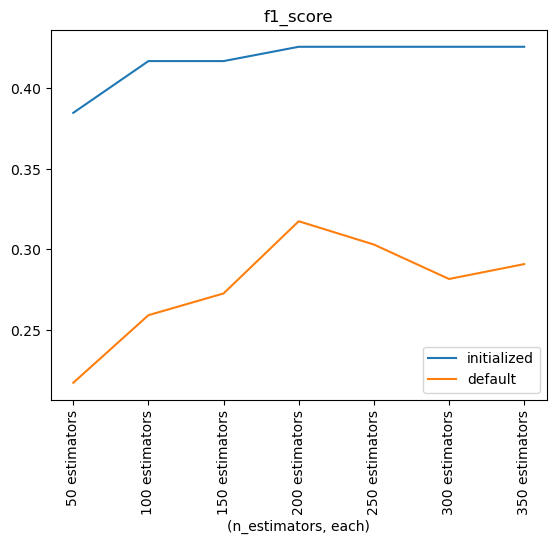

In [111]:
results_df['f1_score'].plot(rot=90, title='f1_score')

<AxesSubplot:title={'center':'log_loss'}, xlabel='(n_estimators, each)'>

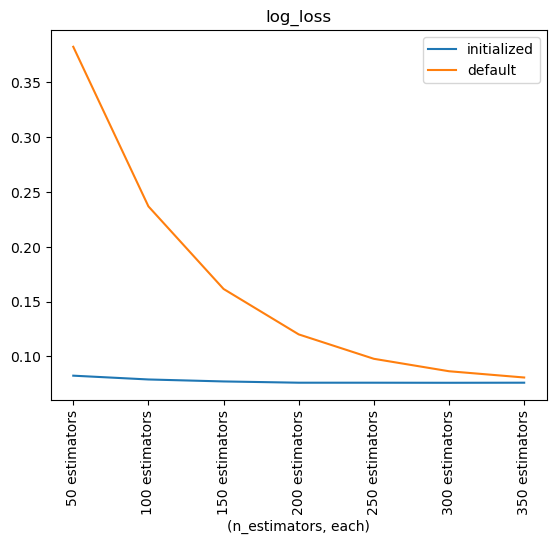

In [113]:
new_results_df['log_loss'].plot(rot=90, title='log_loss')

It's pretty clear from this experiment that the "initialized" model achieves substantially better performance.  It's much more well calibrated (as measured by the log loss) from the very beginning, and the f1 score it achieves is also much better than that using the default initialization.

In particular, the best f1 score the default model achieves is only 0.32 compared to the properly initialized model with an f1 score of 0.42.  